# WP7 - Exercise 1

---

### Support functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')   ## reset!
plt.style.use('paper.mplstyle')

def shear( sig_n, s1, s2 ) :
    """ 
    Creates a shear series for given values of principal stresses and sig_n
    """
    center = (s1 + s2)/2
    radius = (s1 - s2)/2
    dx = sig_n - center
    tau_sq = radius * radius - dx * dx
    tau_sq[ tau_sq < 0 ] = None
    return np.sqrt( tau_sq )

def mohr2d(s1, s3, ax, title="") :
    """ 
    Plot Mohr diagram 
    """
    # Setup data
    npts = 1000
 
    [s1,s3] = sorted([s1,s3], reverse=True)
    step = (s1-s3)/npts
    sig_n = np.sort( np.append( np.arange(s3,s1,step), [s1, s3]) )
    
    s13_tau = shear( sig_n, s1, s3 )

    # Do the plotting stuff
    ax.plot(sig_n, s13_tau, c='gray')

    ax.set_title(title, fontsize=20)
    ax.set_ylabel("Shear stress ($\\tau$)")
    ax.set_xlabel("Effective normal stress ($\sigma_n$)")

    return ax 


### Determine the best fitting parameters of a Coulomb criterion: $\sigma_1 = UCS + q \sigma_3$.

UCS=80.44 MPa q=4.5881


,S3_MPa,Pp_MPa,S1_MPa,Sig3_MPa,Sig1_MPa,I1_MPa,J2_MPa2,sqrt_J2_MPa
1,110,40.730779,409.023317,69.269221,368.292538,506.830979,29804.981366,172.641193
2,110,76.019958,342.219591,33.980042,266.199633,334.159717,17975.312781,134.072043
3,110,110.014132,189.773495,-0.014132,79.759362,79.731098,2121.270155,46.057249
4,70,-0.055399,399.750377,70.055399,399.805776,539.916574,36245.103735,190.381469
5,70,16.932524,339.904257,53.067476,322.971732,429.106683,24282.769258,155.829295
6,70,33.748003,288.242137,36.251997,254.494134,326.998129,15876.543480,126.002157
7,70,50.737176,226.162799,19.262824,175.425623,213.951271,8128.939967,90.160634
8,70,69.921900,140.320493,0.078100,70.398593,70.554794,1648.323920,40.599556
9,35,-0.145370,260.542030,35.145370,260.687400,330.978141,16956.402398,130.216752
10,35,7.266436,214.585236,27.733564,207.318800,262.785928,10750.285693,103.683584


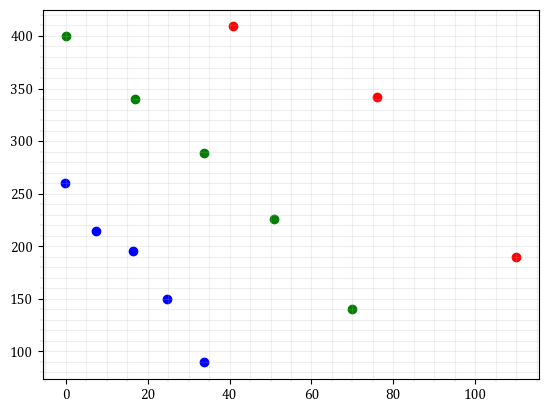

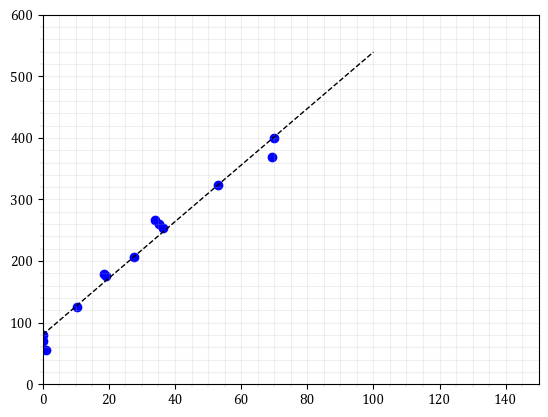

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_excel("DarleyDaleDataset.xlsx")
df["Sig3_MPa"] = df.S3_MPa - df.Pp_MPa
df["Sig1_MPa"] = df.S1_MPa - df.Pp_MPa
# Filter values beyond the linearity
df = df[df.Sig3_MPa < 100]

df["I1_MPa"] = df.Sig1_MPa + 2*df.Sig3_MPa
s1=df.Sig1_MPa
s3=df.Sig3_MPa
df["J2_MPa2"] = 1/6*( 2 * (s1-s3)**2 )
df["sqrt_J2_MPa"] = np.sqrt(df.J2_MPa2)


fig, ax = plt.subplots()
for name, g in df.groupby('S3_MPa'):
    ax.scatter(g.Pp_MPa, g.S1_MPa)

from scipy.stats import linregress
Q, UCS, r_value, p_value, std_err = linregress( df.Sig3_MPa, df.Sig1_MPa )
Sig1_fit = np.linspace(0,100,10)
Sig3_fit = Sig1_fit * Q + UCS

fig, ax = plt.subplots()
ax.scatter(df.Sig3_MPa, df.Sig1_MPa)
ax.plot(Sig1_fit, Sig3_fit, ls='--', color='k')
ax.set_xlim(0,150)
ax.set_ylim(0,600)

print(f"UCS={UCS:.2f} MPa q={Q:.4f}")
df

### Determine the corresponding values of cohesive strength $S_0$ and friction angle $\varphi$ from point (1) and draw the shear failure line together with Mohr circles at failure. 

S0=18.78 MU=0.8376  PHI=39.95 deg


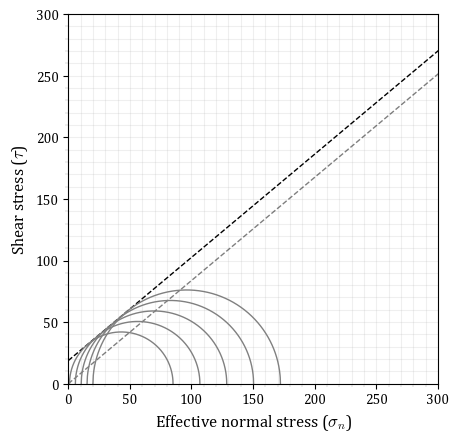

In [8]:
S0 = UCS / 2 / np.sqrt(Q)
MU = (Q-1) / 2 / np.sqrt(Q)

PHI = np.arctan(MU) 

print(f"S0={S0:.2f} MU={MU:.4f}  PHI={PHI*180/np.pi:.2f} deg")

sign=np.linspace(0,400,10)
tau = S0 + MU * sign

fig, ax = plt.subplots()
ax.plot(sign, tau, ls='--', color='k')
ax.plot(sign, tau-S0, ls='--', color='k', alpha=0.5)
ax.set_xlim(0,300)
ax.set_ylim(0,300)

sig1_sig3 = Q
for sig3 in np.linspace(1,20,5) :
#    sig1 = sig1_sig3 * ( sig3 + S0 )
    sig1 = sig1_sig3 * ( sig3 + S0/MU ) - S0/MU
    mohr2d(sig1, sig3, ax)

ax.set_aspect('equal', 'box')

### Determine the corresponding fitting parameters for a Drucker-Prager criterion and plot experimental data in a $I_1$ v.s. $(J_2)^{1/2}$ space. 

Drucker-Prager:
   C3=20.35 C4=0.3174


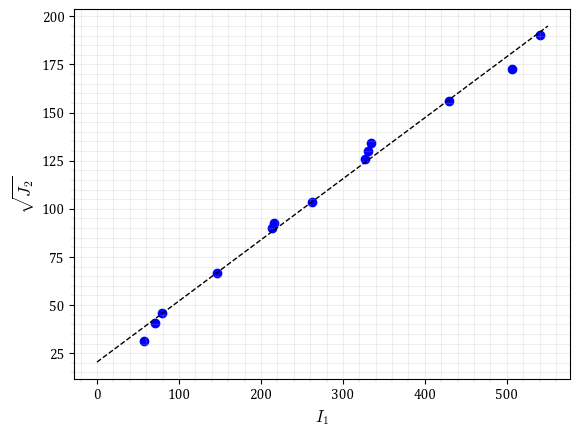

In [9]:
fig, ax = plt.subplots()
ax.scatter( df.I1_MPa, df.sqrt_J2_MPa )

from scipy.stats import linregress
C4, C3, r_value, p_value, std_err = linregress( df.I1_MPa, df.sqrt_J2_MPa  )
X = np.linspace(0,550,10)
Y = C3 + C4 * X
ax.plot( X, Y, c='k', ls='--' )

ax.set_xlabel("$I_1$")
ax.set_ylabel("$\sqrt{J_2}$")

print("Drucker-Prager:")
print(f"   C3={C3:.2f} C4={C4:.4f}")

### Compute the corresponding tensile strength assuming a reasonable ratio of unconfined compression strength to tensile strength (browse Jaeger’s book). 
----

As of Section 4.5 and 4.6 of Jaeger's book, we can understand that a reasonable ration for $C_0/T_0 = [ \sqrt{\mu^2+1} + \mu ]^2$.

In [10]:
c0_t0 = ( np.sqrt( MU**2 + 1 ) + MU ) ** 2

C0 = UCS
T0 = C0 / c0_t0

print(f"C_0/T_0 = {c0_t0:.2f}")
print(f"UCS = {UCS:.2f}   T_0 = {T0:.2f} MPa")


C_0/T_0 = 4.59
UCS = 80.44   T_0 = 17.53 MPa


# WP7 - Exercise 2

---

#### The likelihood of tensile fractures considering wellbore mud pressure is equal to pore pressure in the formation $P_W = P_p$ and a simple tensile strength criterion (independent of intermediate and maximum principal stresses), i.e., required $T_s$. 

In [2]:
#
#
#
def Sp_to_Sg(Sp, alpha, beta, gamma) :
  # ROTATION MATRIX
  CA, SA = np.cos(alpha), np.sin(alpha)
  CB, SB = np.cos(beta),  np.sin(beta)
  CG, SG = np.cos(gamma), np.sin(gamma)
  RPG = np.array(
        [ [ CA*CB,                SA*CB            ,   -SB  ],
          [ CA*SB*SG - SA*CG,     SA*SB*SG + CA*CG , CB*SG  ],
          [ CA*SB*CG + SA*SG,     SA*SB*CG - CA*SG , CB*CG  ]]
  )

  # MATRIX MULTIPLICATION - STRESS IN GEOGRAPHIC COORDINATES
  Sg = RPG.T @ Sp @ RPG
  return Sg

#
#
#
def Sg_to_Sw(Sg, delta, phi) :
  # ROTATION MATRIX
  CD = np.cos(delta)
  SD = np.sin(delta)
  CP = np.cos(phi)
  SP = np.sin(phi)
  
  Rb = np.array(
        [ [ -CD*CP,   -SD*CP ,  SP  ],
          [ SD,       -CD    ,   0  ],
          [ CD*SP,     SD*SP ,  CP  ]]
  )

  Sw = Rb @ Sg @ Rb.T
  return Sw

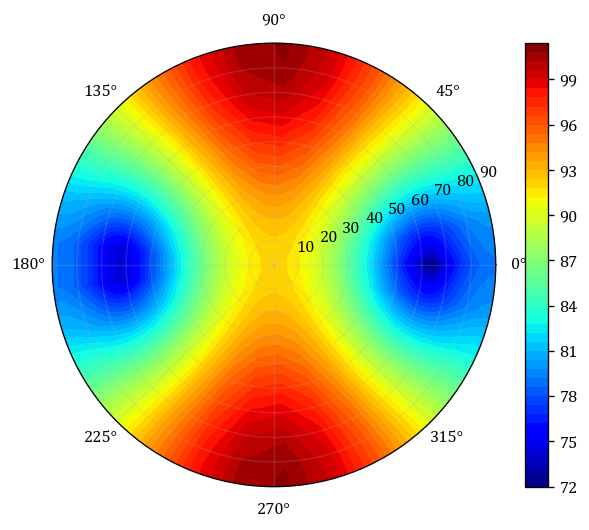

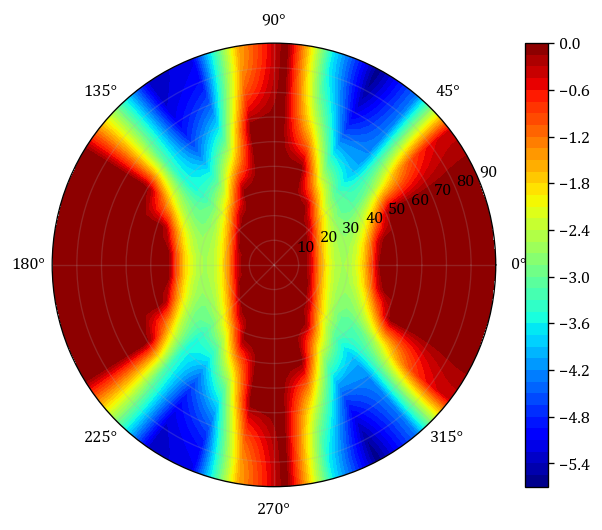

In [3]:
import numpy as np
import pandas as pd
from numpy import sin, cos, pi
from numpy.linalg import eigvals
import matplotlib.pyplot as plt


# MPa
Sv = 70
Shmax = 67 
Shmin = 45

Pp = 32
Pw = 32
Delta_P = 0
NU = 0.5
# Sp
Sp = [[ Sv, 0, 0 ],[ 0, Shmax, 0],[ 0, 0, Shmin]]

# Normal        : az, pi/2, 0
# Strike slip   : az, 0,    pi/2
# Reverse       : az, 0,    0
Sg = Sp_to_Sg(Sp, 0, pi/2, 0)

phimesh, deltamesh = np.meshgrid( np.linspace(0,pi/2,30), np.linspace(0,2*np.pi,30) )
Ts = np.zeros_like( deltamesh )
UCS = np.zeros_like( deltamesh )

for i in np.arange(len(deltamesh)) :
    for j in np.arange(len(deltamesh[i])):
        delta = deltamesh[i,j]
        phi = phimesh[i,j]
        Sw = Sg_to_Sw(Sg, delta, phi)
        s1_list = []
        s3_list = []
        for theta in np.linspace(0,2*np.pi,120):  # Angle around the borehole
            sig11 = Sw[0,0] - Pp
            sig22 = Sw[1,1] - Pp
            sig33 = Sw[2,2] - Pp
            sig12 = Sw[0,1]
            sig23 = Sw[1,2]
            sig13 = Sw[0,2]
            
            srr = Delta_P
            stt = sig11 + sig22 - 2*(sig11-sig22)*cos(2*theta) - 4*sig12*sin(2*theta) - Delta_P 
            szt = 2 * ( sig23*cos(theta) - sig13*sin(theta) )
            szz = sig33 - 2*NU*(sig11-sig22)*cos(2*theta) - 4*NU*sig12*sin(2*theta) 

            ST = [ [ srr, 0, 0 ], [ 0, stt, szt ], [ 0, szt, szz] ]
            EV = sorted(eigvals(ST), reverse=True)
            s1_list.append(EV[0])
            s3_list.append(EV[2])
            
        Ts[i,j] = np.min( s3_list )
        UCS[i,j] = np.max( s1_list )

fig, ax = plt.subplots(dpi=120, subplot_kw=dict(projection='polar'))
CS = ax.contourf( deltamesh, phimesh*180/pi, UCS, cmap='jet', levels=50 ) # contourf or pcolormesh
cbar = fig.colorbar(CS)

fig, ax = plt.subplots(dpi=120, subplot_kw=dict(projection='polar'))
CS = ax.contourf( deltamesh, phimesh*180/pi, Ts, cmap='jet', levels=50 ) # contourf or pcolormesh
cbar = fig.colorbar(CS)
